# **1. Mengimpor library yang diperlukan**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

import joblib

# **2. Data Understanding**

Memuat dataset dari file CSV ke dalam variabel DataFrame.

In [2]:
# Load dataset
df = pd.read_csv('/content/sample_data/accelerometer_gyro_mobile_phone_dataset.csv')
print(df.head())

       accX      accY      accZ     gyroX     gyroY     gyroZ timestamp  \
0 -0.496517  3.785628  8.954828 -0.142849 -0.126159 -0.022539   34:22.9   
1 -0.462388  3.869603  9.281898  0.084349  0.096695  0.092130   34:23.0   
2 -0.296084  3.820505  8.930728  0.061763  0.051543  0.071287   34:23.1   
3 -0.469723  3.890110  8.744067  0.007641  0.028679  0.109433   34:23.2   
4 -0.472418  4.109105  8.941207 -0.123640  0.099057  0.051943   34:23.3   

   Activity  
0         1  
1         1  
2         1  
3         1  
4         1  


Menampilkan informasi awal dan struktur dasar dari dataset yang disimpan dalam sebuah DataFrame df

In [3]:
# Informasi Awal & Preprocessing Dasar
print("Info Dataset:")
print(df.info())

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31991 entries, 0 to 31990
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   accX       31991 non-null  float64
 1   accY       31991 non-null  float64
 2   accZ       31991 non-null  float64
 3   gyroX      31991 non-null  float64
 4   gyroY      31991 non-null  float64
 5   gyroZ      31991 non-null  float64
 6   timestamp  31991 non-null  object 
 7   Activity   31991 non-null  int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 2.0+ MB
None


Ringkasan dataset :


1.   Jumlah Total Baris (Data/Entitas): 31.991
2.   Jumlah Total Kolom (Fitur/Variabel): 8
3.   Tipe data sudah sesuai untuk fitur numerik (float64) dan label (int64).

In [4]:
print("\nStatistik Deskriptif:")
print(df.describe())


Statistik Deskriptif:
               accX          accY          accZ         gyroX         gyroY  \
count  31991.000000  31991.000000  31991.000000  31991.000000  31991.000000   
mean       0.023825      2.153858      9.537909     -0.004493     -0.014756   
std        0.741396      1.085466      2.056358      0.307643      0.249201   
min       -3.673361     -4.386029      4.296066     -1.470421     -1.430659   
25%       -0.472193      1.413062      7.794217     -0.149783     -0.162656   
50%       -0.024998      2.119143      9.406739      0.022301     -0.011060   
75%        0.477208      2.928435     11.158845      0.177978      0.124966   
max        4.678671      6.377039     17.591568      1.332722      1.480135   

              gyroZ      Activity  
count  31991.000000  31991.000000  
mean      -0.007021      0.982151  
std        0.266120      0.132404  
min       -1.894102      0.000000  
25%       -0.154126      1.000000  
50%        0.005261      1.000000  
75%        0.

**Distribusi Data Sensor Accelerometer (accX, accY, accZ)**

**1. accX (Percepatan Sumbu X):**

- Rata-rata mendekati nol (mean = 0.024) dengan deviasi standar 0.741, menunjukkan variasi gerakan yang cukup besar.

- Rentang nilai lebar (min = -3.673 hingga max = 4.679), mengindikasikan adanya outlier atau gerakan ekstrem.

- Distribusi simetris (median ≈ mean).

**2. accY (Percepatan Sumbu Y):**

- Rata-rata positif (mean = 2.154) dengan deviasi standar 1.085, menandakan dominasi nilai positif (gravitasi atau orientasi perangkat).

- Nilai minimum (-4.386) dan maksimum (6.377) menunjukkan variasi signifikan, mungkin akibat perubahan orientasi smartphone.

**3. accZ (Percepatan Sumbu Z):**

- Rata-rata tinggi (mean = 9.538) dengan deviasi standar 2.056, konsisten dengan pengaruh gravitasi bumi (biasanya ~9.8 m/s²).

- Rentang nilai (4.296 hingga 17.592) mencerminkan perubahan percepatan saat perangkat bergerak.

**Distribusi Data Sensor Gyroscope (gyroX, gyroY, gyroZ)**

**1. gyroX, gyroY, gyroZ :**

- Rata-rata mendekati nol (mean ≈ -0.004 hingga -0.007), sesuai dengan ekspektasi saat perangkat diam atau bergerak stabil.

- Deviasi standar kecil (0.249–0.308), menunjukkan fluktuasi rotasi yang relatif stabil.

- Nilai ekstrem (misal: gyroZ min = -1.894, max = 1.482) mengindikasikan gerakan rotasional tiba-tiba.

**Insight Penting :**

- Outlier Potensial : Terlihat dari nilai min/max yang jauh dari Q1/Q3 (misal: accY min = -4.386, sedangkan Q1 = 1.413).

- Perbedaan Pola Sensor : Accelerometer (accX, accY, accZ) memiliki variasi lebih besar dibanding gyroscope, sesuai dengan sifat pengukuran percepatan vs rotasi.

- Dampak pada Model : Ketidakseimbangan kelas dapat menyebabkan bias model terhadap kelas mayoritas (Walk).

# **3. Univariate Analysis (Analisis Satu Per Satu Fitur)**

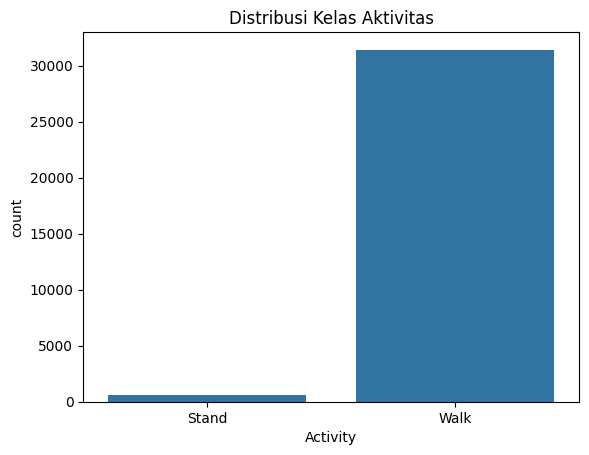

In [5]:
# Distribusi Aktivitas
sns.countplot(data=df, x='Activity')
plt.title('Distribusi Kelas Aktivitas')
plt.xticks([0, 1], ['Stand', 'Walk'])
plt.show()

Dari hasil diagram diatas distribusi data sangat tidak seimbang, aktivitas walk jauh lebih tinggi dibanding stand.

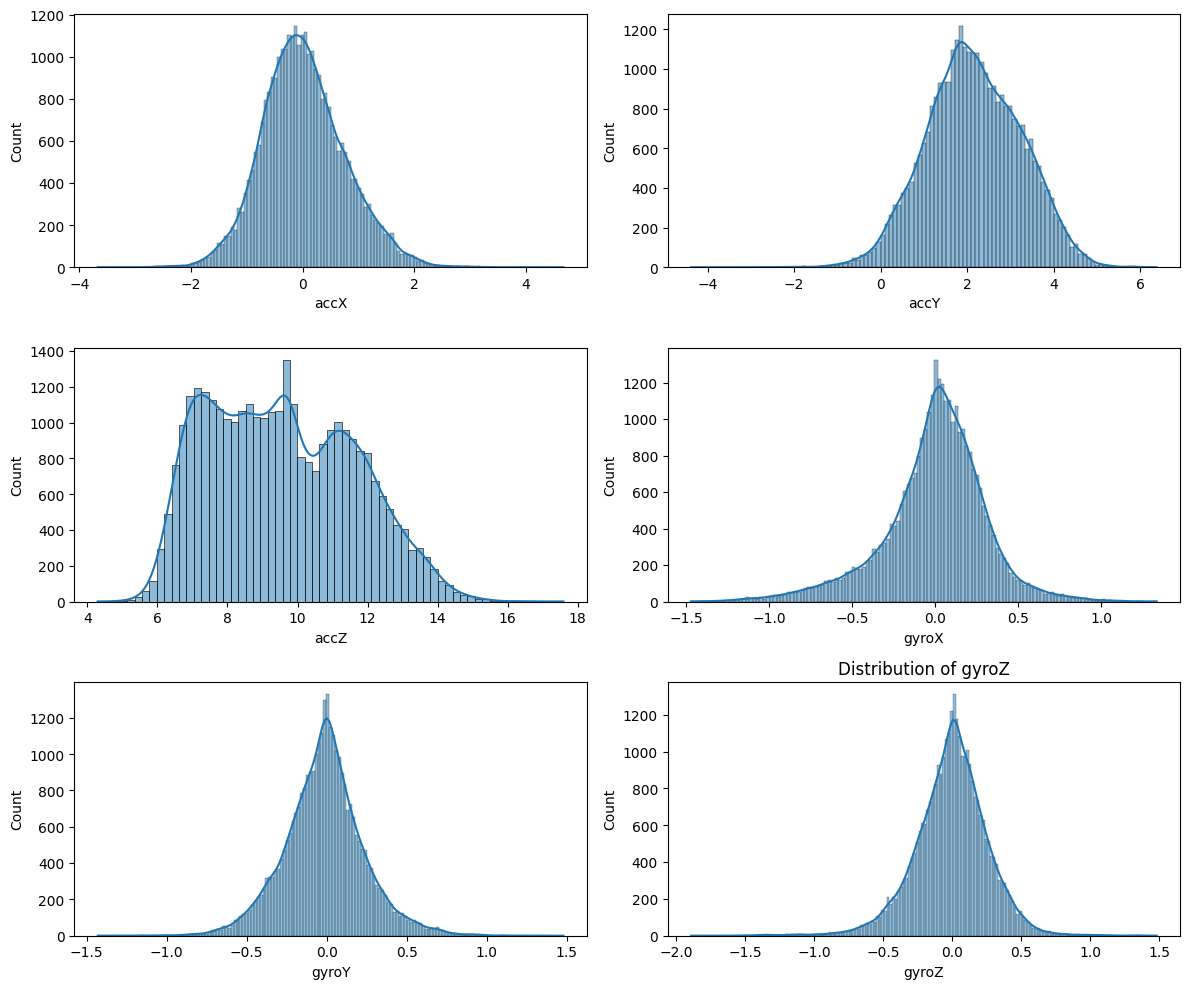

In [7]:
# Distribusi Setiap Fitur Numerik (tanpa timestamp)
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
features = [col for col in df.columns if col not in ['Activity', 'timestamp']]  # exclude both target and timestamp

for i, feature in enumerate(features):
    sns.histplot(df[feature], ax=axes[i//2, i%2], kde=True)
    plt.title(f'Distribution of {feature}')

# Hide any empty subplots if there are odd number of features
if len(features) < 6:
    for j in range(len(features), 6):
        axes.flatten()[j].set_visible(False)

plt.tight_layout()
plt.show()

Hasil histogram menunjukkan distribusi yang bervariasi untuk setiap fitur. Nilai accX terdistribusi cukup simetris di sekitar angka 0, sementara accY cenderung miring ke kiri dengan sebagian besar data terkonsentrasi di nilai positif sekitar 2. Untuk accZ, data lebih banyak berada di kisaran 9–11 dengan ekor panjang ke arah nilai yang lebih besar, menunjukkan kemiringan ke kanan. Sementara itu, gyroX dan gyroY memiliki puncak tajam di angka 0 dengan distribusi yang relatif simetris, meskipun gyroY sedikit miring ke kiri. Secara umum, data gyro lebih stabil dan terpusat dibandingkan data akselerometer yang lebih tersebar.

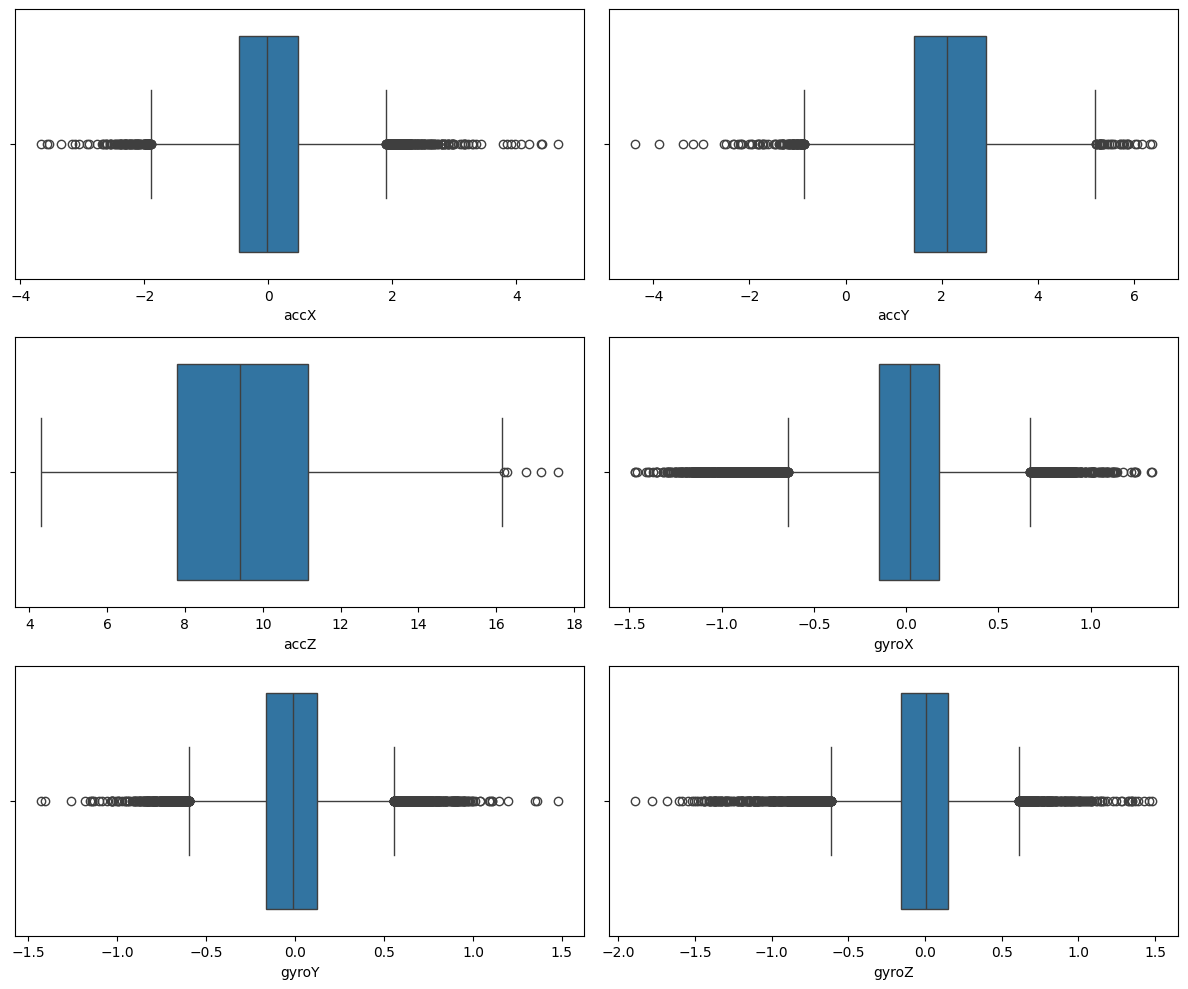

In [8]:
# Boxplot untuk Deteksi Outlier
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
for i, feature in enumerate(features):
    sns.boxplot(x=df[feature], ax=axes[i//2, i%2])
plt.tight_layout()
plt.show()

Boxplot dari keenam fitur numerik menunjukkan bahwa seluruh fitur memiliki outlier, yang terlihat dari banyaknya titik di luar whisker (garis batas bawah dan atas). Fitur seperti accX, accY, dan semua fitur gyro (gyroX, gyroY, gyroZ) memiliki outlier di kedua sisi distribusi, mengindikasikan adanya nilai ekstrim yang mungkin terjadi karena pergerakan mendadak atau noise dari sensor. Sementara accZ, meskipun juga mengandung outlier, distribusinya lebih melebar dan memiliki persebaran data yang lebih bervariasi. Banyaknya outlier ini tidak selalu berarti data error, bisa jadi mencerminkan kejadian penting dalam aktivitas fisik.

# **4. Bivariate Analysis (Antara Fitur dan Label)**

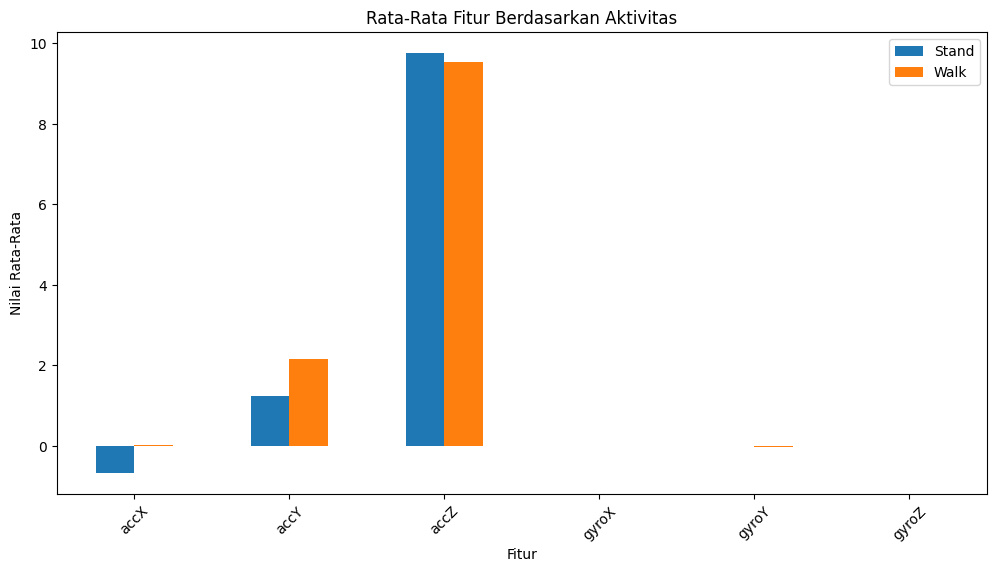

In [9]:
# Rata-rata Fitur Berdasarkan Aktivitas
df_grouped = df.groupby('Activity')[features].mean().T
df_grouped.plot(kind='bar', figsize=(12,6), title='Rata-Rata Fitur Berdasarkan Aktivitas')
plt.ylabel('Nilai Rata-Rata')
plt.xlabel('Fitur')
plt.legend(['Stand', 'Walk'])
plt.xticks(rotation=45)
plt.show()

Berdasarkan grafik rata-rata fitur berdasarkan aktivitas, terlihat bahwa sensor accelerometer (terutama accY dan accZ) menunjukkan perbedaan yang cukup jelas antara aktivitas berdiri (stand) dan berjalan (walk) , sehingga menjadi fitur yang informatif untuk klasifikasi. Sementara itu, nilai dari sensor gyroscope (gyroX, gyroY, gyroZ) hampir tidak menunjukkan perbedaan antar kedua aktivitas, sehingga mungkin kurang relevan dalam membedakan keduanya. Hal ini menunjukkan bahwa model dapat lebih fokus pada fitur dari accelerometer untuk mencapai performa yang optimal.

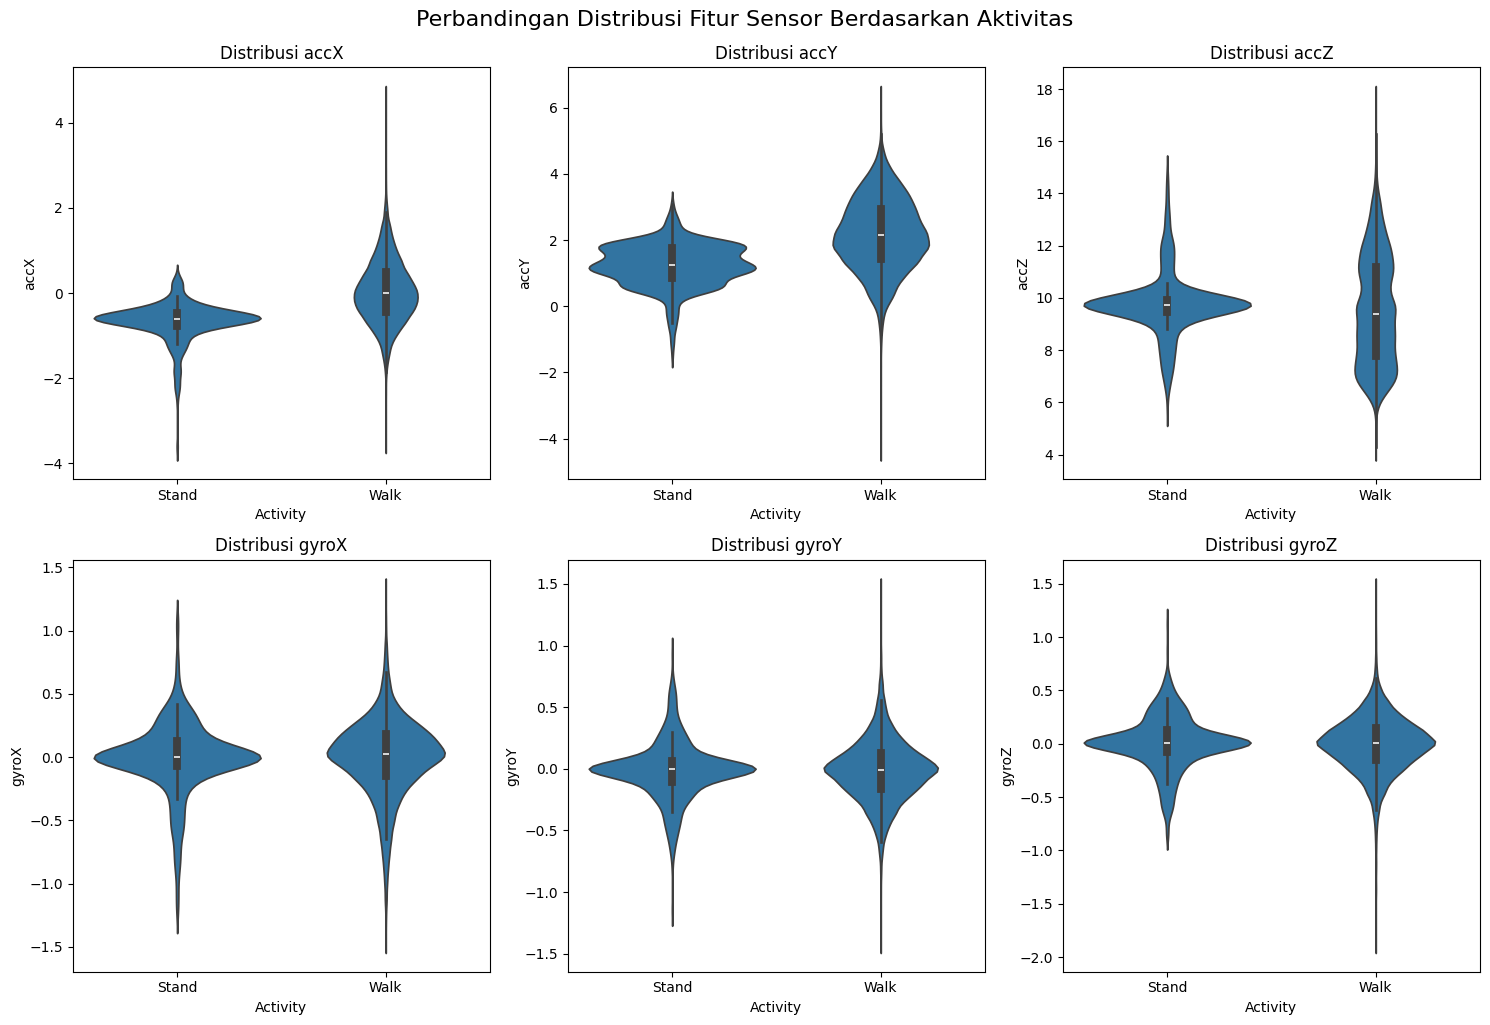

In [23]:
# Violin Plot untuk Membandingkan Distribusi Antar Aktivitas

# Set ukuran figure dan layout
plt.figure(figsize=(15, 10))

# Membuat grid 2x3 untuk 6 fitur
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x='Activity', y=feature, data=df)
    plt.xticks([0, 1], ['Stand', 'Walk'])
    plt.title(f'Distribusi {feature}')
    plt.tight_layout()

plt.suptitle('Perbandingan Distribusi Fitur Sensor Berdasarkan Aktivitas', y=1.02, fontsize=16)
plt.show()

Violin plot ini menunjukkan distribusi nilai accZ (percepatan sumbu Z) untuk dua aktivitas berbeda: berdiri (Stand) dan berjalan (Walk). Bentuk violin yang melebar di bagian atas untuk aktivitas berjalan menunjukkan variasi nilai yang lebih besar, sementara aktivitas berdiri cenderung lebih terkonsentrasi di kisaran nilai tertentu. Hal ini masuk akal karena gerakan berjalan biasanya menghasilkan perubahan percepatan yang lebih dinamis dibandingkan berdiri diam. Plot ini membantu membedakan pola kedua aktivitas, di mana accZ bisa menjadi fitur yang berguna untuk klasifikasi dalam analisis gerakan.

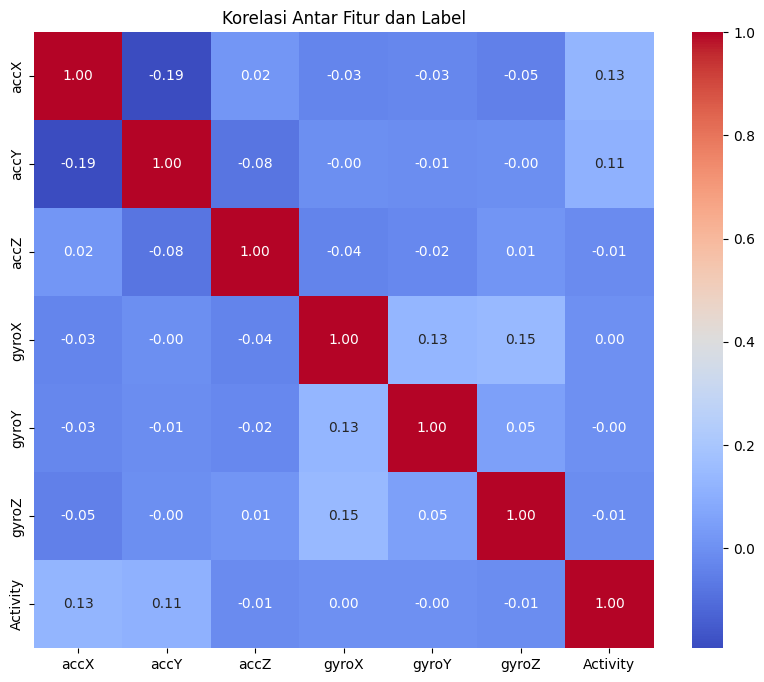

In [24]:
# Korelasi Antar Fitur
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi Antar Fitur dan Label')
plt.show()

Dari peta korelasi ini, terlihat bahwa sebagian besar fitur sensor (seperti accX, accY, accZ, gyroX, gyroY, dan gyroZ) memiliki korelasi yang sangat lemah satu sama lain maupun dengan label Activity, dengan nilai mendekati nol. Hal ini menunjukkan bahwa setiap fitur memberikan informasi yang relatif independen, yang bisa menjadi keuntungan untuk model machine learning karena mengurangi risiko redundansi data. Namun, korelasi yang rendah dengan Activity (nilai tertinggi hanya -0,13) juga mengindikasikan bahwa fitur-fitur ini mungkin tidak terlalu kuat dalam memprediksi aktivitas secara individual, sehingga perlu dikombinasikan atau diolah lebih lanjut untuk meningkatkan akurasi klasifikasi.

# **5. Multivariate Analysis**

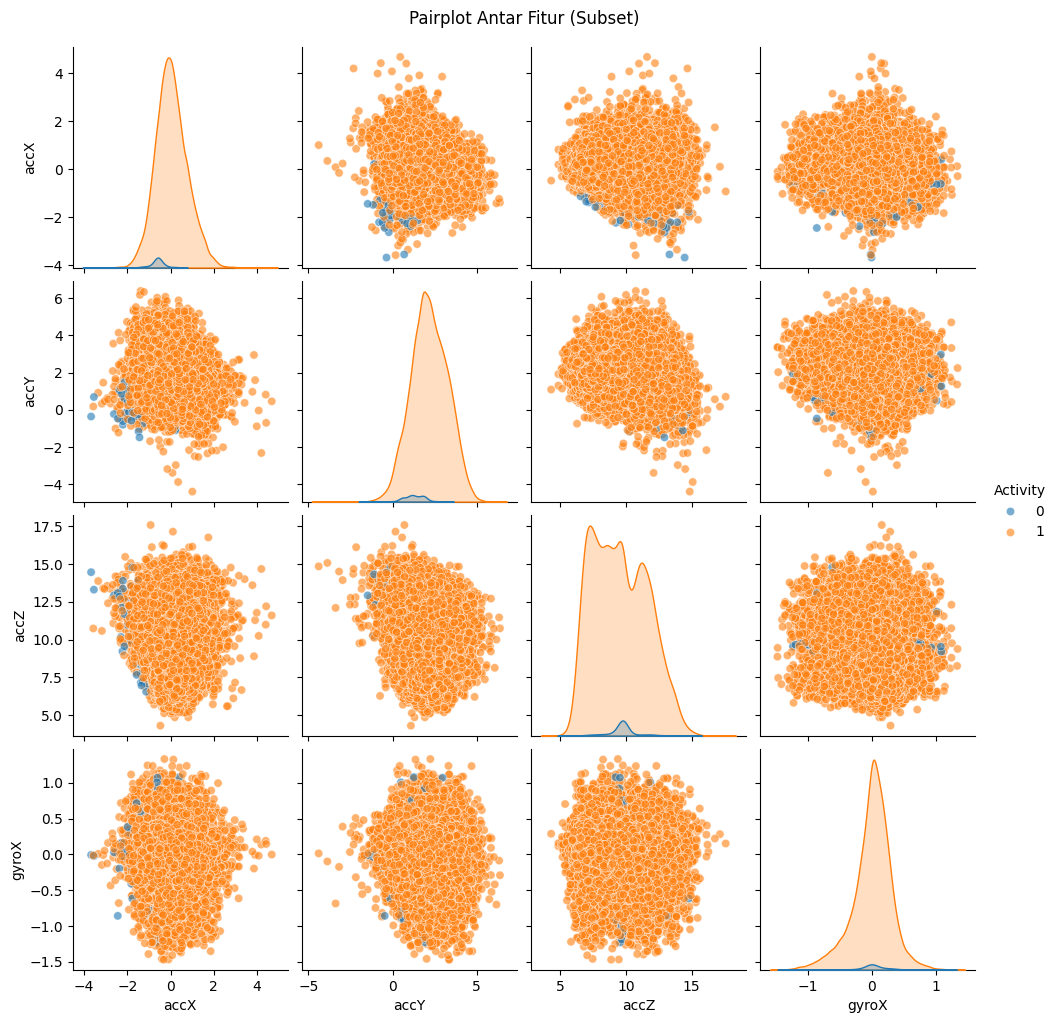

In [25]:
# Pairplot untuk Subset Fitur
sns.pairplot(data=df[['accX', 'accY', 'accZ', 'gyroX', 'Activity']], hue='Activity', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot Antar Fitur (Subset)', y=1.02)
plt.show()

Pairplot ini memperlihatkan hubungan antar fitur accX, accY, accZ, dan gyroX terhadap dua aktivitas berbeda (label 0 dan 1). Secara umum, titik-titik dari kedua aktivitas tampak cukup tumpang tindih satu sama lain, yang menunjukkan bahwa pemisahan antar kelas berdasarkan kombinasi fitur ini tidak terlalu jelas secara visual. Namun, ada sedikit kecenderungan distribusi fitur seperti accZ dan accY yang bisa membantu membedakan kelas, meskipun tidak terlalu dominan.

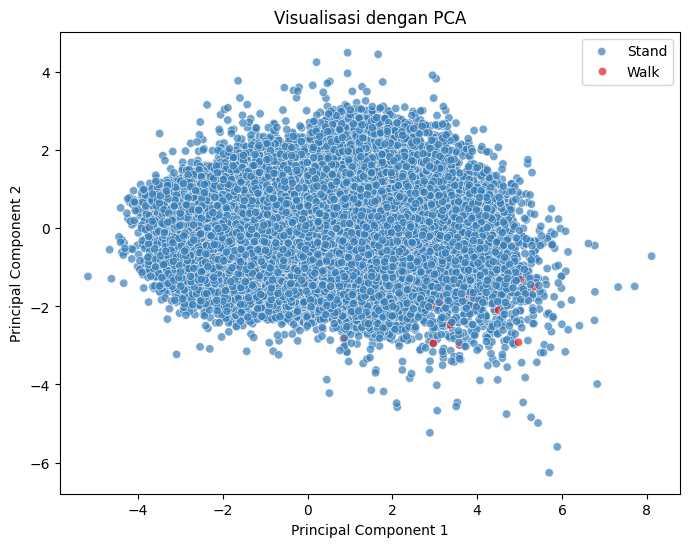

In [27]:
# PCA Visualization (Reduksi Dimensi ke 2D)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df.drop(columns=['Activity']))

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Activity'], palette='Set1', alpha=0.7)
plt.title('Visualisasi dengan PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(['Stand', 'Walk'])
plt.show()

Visualisasi PCA ini menunjukkan proyeksi data berdimensi tinggi ke dalam dua komponen utama (Principal Component 1 dan 2) untuk melihat pemisahan antara dua aktivitas: Stand dan Walk. Dari grafik ini, terlihat bahwa sebagian besar data didominasi oleh aktivitas Stand (ditandai warna biru), sementara aktivitas Walk (merah) hanya muncul di area terbatas dan sangat sedikit. Hal ini menunjukkan bahwa data Walk kemungkinan jauh lebih sedikit dibanding Stand, atau fitur-fitur yang ada belum cukup kuat membedakan kedua aktivitas tersebut dalam ruang dua dimensi. Artinya, meskipun PCA membantu menyederhanakan data, informasi yang dihasilkan masih belum optimal untuk memisahkan kedua aktivitas secara jelas, sehingga dibutuhkan pendekatan tambahan seperti pemrosesan fitur lebih lanjut atau algoritma klasifikasi yang lebih kompleks.

# **6. Data Preparation**

In [15]:
# Drop timestamp karena tidak relevan
df = df.drop(columns=['timestamp'])

Menghapus kolom timestamp karena tidak diperlukan.

In [18]:
# Mengecek data duplikat
df.duplicated().sum()

np.int64(144)

Terdapat 144 data duplikat, karena jumlahnya yang kecil maka diputuskan untuk dihapus.

In [19]:
# Menghapus data duplikat
df.drop_duplicates(inplace=True)

In [16]:
# Train-Test Split & Scaling

X = df.drop(columns=['Activity'])
y = df['Activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Data fitur (X) dipisahkan dari target (y) dengan menghapus kolom 'Activity' dari DataFrame. Kemudian, data dibagi menjadi data latih dan data uji dengan perbandingan 80:20 menggunakan stratifikasi agar distribusi kelas pada target tetap seimbang.

In [20]:
# Melakukan standarisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Selanjutnya, dilakukan standarisasi fitur menggunakan StandardScaler, di mana data latih diubah agar memiliki rata-rata 0 dan standar deviasi 1, lalu transformasi yang sama juga diterapkan ke data uji.

# **7. Data Modelling**

In [21]:
def evaluate_model(model, name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 'Tidak tersedia'
    print("ROC AUC Score:", roc_auc)
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return model

=== Logistic Regression ===
Accuracy: 0.981872167526176
ROC AUC Score: 0.8892754958198997
              precision    recall  f1-score   support

           0       0.40      0.04      0.06       114
           1       0.98      1.00      0.99      6285

    accuracy                           0.98      6399
   macro avg       0.69      0.52      0.53      6399
weighted avg       0.97      0.98      0.97      6399



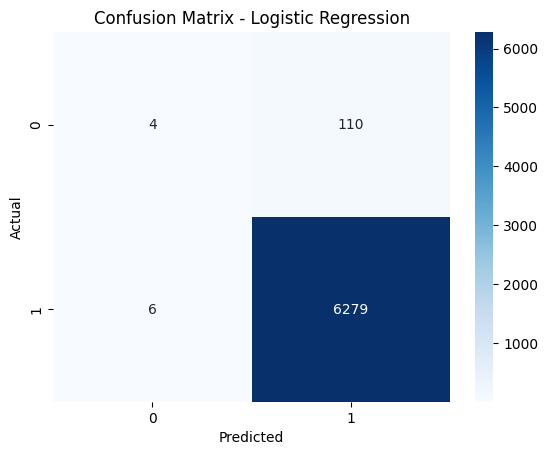

LogisticRegression(max_iter=1000)

In [28]:
# Logistic Regresion
lr = LogisticRegression(max_iter=1000)
evaluate_model(lr, "Logistic Regression", X_train_scaled, y_train, X_test_scaled, y_test)

Hasil pelatihan model Logistic Regression menunjukkan akurasi sangat tinggi (98.2%), namun ini menutupi masalah serius dalam klasifikasi:

**Kinerja Buruk untuk Kelas Minoritas (Kelas 0):**

1. Hanya 4% recall (hanya 4 dari 114 data kelas 0 yang benar terprediksi), dengan F1-score 0.06.

2. Precision 0.40 berarti 60% prediksi "kelas 0" ternyata salah.

**Dominasi Kelas Mayoritas (Kelas 1):**

1. Hampir sempurna (precision 0.98, recall 1.00) karena kelas 1 mendominasi 98% data (6256/6370).

2. ROC AUC 0.89 mengindikasikan model bisa membedakan kedua kelas, tapi tidak optimal untuk kelas minoritas.

=== SVM Balanced ===
Accuracy: 0.8726363494295983
ROC AUC Score: 0.942272746304903
              precision    recall  f1-score   support

           0       0.11      0.89      0.20       114
           1       1.00      0.87      0.93      6285

    accuracy                           0.87      6399
   macro avg       0.55      0.88      0.56      6399
weighted avg       0.98      0.87      0.92      6399



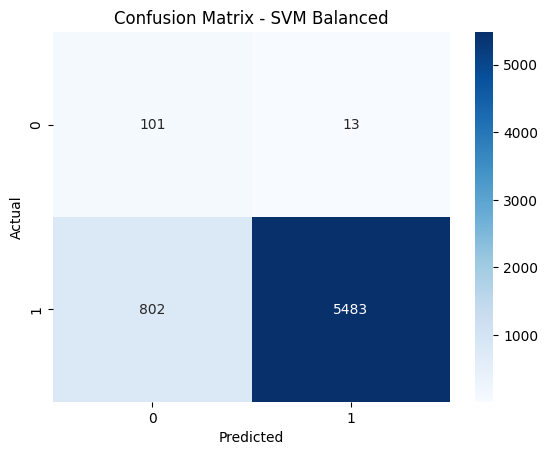

SVC(class_weight='balanced', probability=True)

In [29]:
# SVM
svm_balanced = SVC(probability=True, class_weight='balanced')
evaluate_model(svm_balanced, "SVM Balanced", X_train_scaled, y_train, X_test_scaled, y_test)

Kesimpulan menggunakan algoritma SVM :
1. Deteksi Kelas Minoritas (Kelas 0) jauh lebih baik: Dengan recall 89%, model menjadi lebih sensitif terhadap kelas ini

2. ROC AUC 0.94 menunjukkan kemampuan klasifikasi yang baik secara keseluruhan

3. Kelas Mayoritas (Kelas 1) tetap memiliki precision sempurna (1.00) meski recall turun jadi 87%

4. Precision Kelas 0 masih rendah (11%): Dari semua yang diprediksi sebagai kelas 0, 89% ternyata salah (banyak false positive)

5. Akurasi turun 11% dibanding Logistic Regression, tapi ini wajar karena fokus pada kelas minoritas

=== Decision Tree ===
Accuracy: 0.9760900140646976
ROC AUC Score: 0.6605409705648368
              precision    recall  f1-score   support

           0       0.33      0.33      0.33       114
           1       0.99      0.99      0.99      6285

    accuracy                           0.98      6399
   macro avg       0.66      0.66      0.66      6399
weighted avg       0.98      0.98      0.98      6399



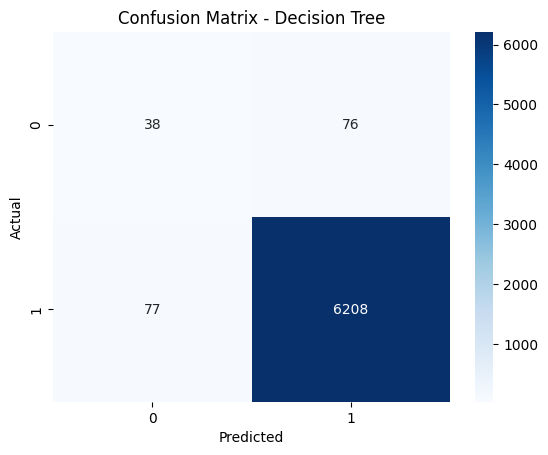

DecisionTreeClassifier(random_state=42)

In [30]:
# Decision tree
dt = DecisionTreeClassifier(random_state=42)
evaluate_model(dt, "Decision Tree", X_train, y_train, X_test, y_test)

Kesimpulan menggunakan algoritma Decision Tree :
1. Recall & Precision sama-sama 33% yang artinya hanya 38 dari 114 data kelas 0 yang benar terdeteksi.
2. F1-score rendah (0.33) yang artinya model kurang mampu menangani ketidakseimbangan data.

=== Random Forest ===
Accuracy: 0.9835911861228317
ROC AUC Score: 0.9246758503258944
              precision    recall  f1-score   support

           0       0.74      0.12      0.21       114
           1       0.98      1.00      0.99      6285

    accuracy                           0.98      6399
   macro avg       0.86      0.56      0.60      6399
weighted avg       0.98      0.98      0.98      6399



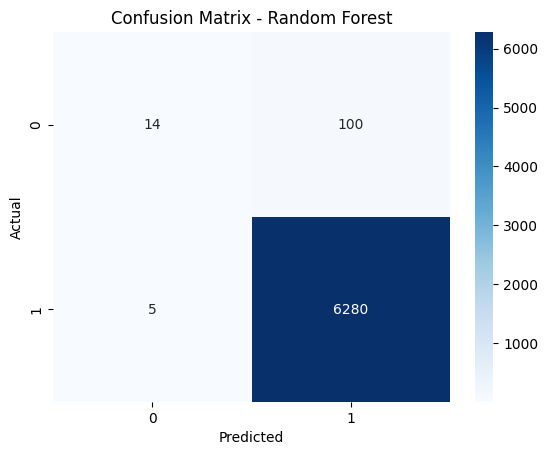

RandomForestClassifier(random_state=42)

In [31]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
evaluate_model(rf, "Random Forest", X_train, y_train, X_test, y_test)

Kesimpulan menggunakan algoritma Random Forest :
1. Akurasi 98.4% & ROC AUC 0.924 (tertinggi dibanding model sebelumnya).
2. Kelas Mayoritas (1) Sempurna: Precision 0.98, Recall 1.00, F1 0.99.

=== XGBoost ===
Accuracy: 0.9839037349585873
ROC AUC Score: 0.9542149925330431
              precision    recall  f1-score   support

           0       0.63      0.24      0.34       114
           1       0.99      1.00      0.99      6285

    accuracy                           0.98      6399
   macro avg       0.81      0.62      0.67      6399
weighted avg       0.98      0.98      0.98      6399



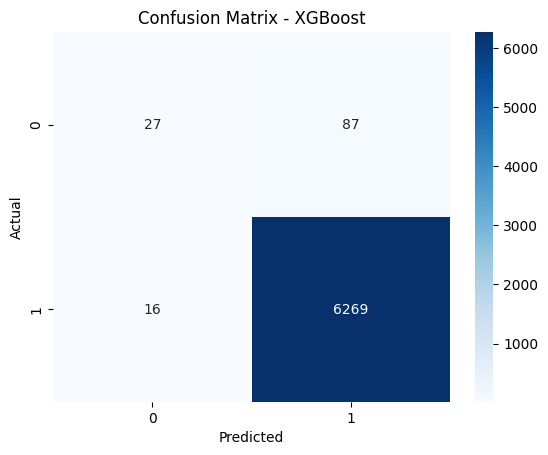

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [32]:
# XGBoost Classifier
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
evaluate_model(xgb, "XGBoost", X_train, y_train, X_test, y_test)

Kesimpulan menggunakan algoritma XGBoost :
1. Akurasi Tertinggi (98.39%) - Sedikit lebih baik dari Random Forest (98.38%).

2. ROC AUC Terbaik (0.954) - Peningkatan signifikan dibanding model lain.

3. Presisi Kelas 0 Meningkat (63%) - Artinya false positive lebih sedikit.

4. Recall Kelas 0 Masih Rendah (24%) - Hanya mendeteksi 1/4 kasus kelas minoritas.

5. F1-Score Kelas 0 yang juga masih rendah (0.34).

**Hyperparamater Tuning (Random Forest)**

Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}
=== Tuned Random Forest ===
Accuracy: 0.9839037349585873
ROC AUC Score: 0.9227853843040378
              precision    recall  f1-score   support

           0       0.82      0.12      0.21       114
           1       0.98      1.00      0.99      6285

    accuracy                           0.98      6399
   macro avg       0.90      0.56      0.60      6399
weighted avg       0.98      0.98      0.98      6399



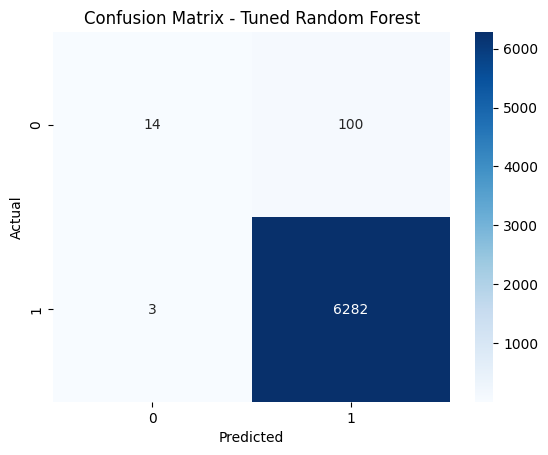

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=50)

In [33]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
evaluate_model(best_rf, "Tuned Random Forest", X_train, y_train, X_test, y_test)

# **8. Evaluation**

**Cross Validation**

In [34]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(dual=False),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

best_score = 0
best_model_name = ""
best_model = None

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    print(f"{name}: {mean_score:.4f} ± {scores.std():.4f}")

    if mean_score > best_score:
        best_score = mean_score
        best_model_name = name
        best_model = model.fit(X_train_scaled, y_train)

print(f"\nModel Terbaik: {best_model_name} dengan skor CV: {best_score:.4f}")

Logistic Regression: 0.9817 ± 0.0004
Linear SVM: 0.9821 ± 0.0001
Decision Tree: 0.9737 ± 0.0010
Random Forest: 0.9835 ± 0.0008
XGBoost: 0.9826 ± 0.0008

Model Terbaik: Random Forest dengan skor CV: 0.9835


**ROC Curve**

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


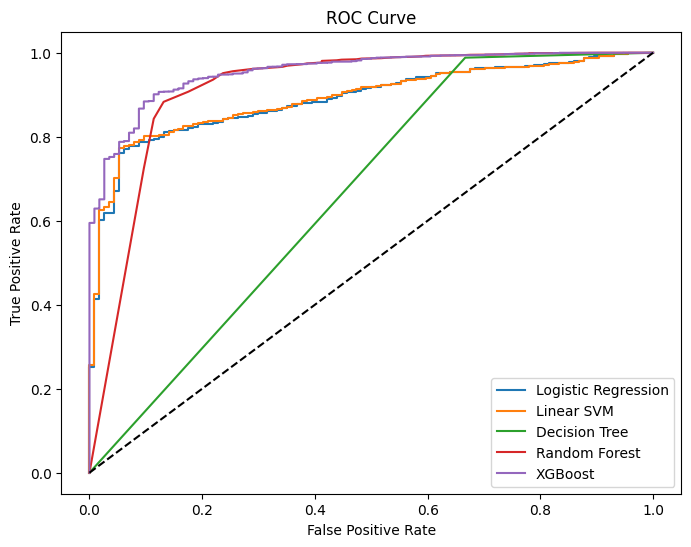

In [35]:
def plot_roc_curve(model, name, X_test, y_test):
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        return

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name}")

plt.figure(figsize=(8, 6))
for model_name, model in models.items():
    if model_name == "Linear SVM":
        # Gunakan CalibratedClassifierCV untuk LinearSVC agar bisa predict_proba
        calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
        calibrated_model.fit(X_train_scaled, y_train)
        plot_roc_curve(calibrated_model, model_name, X_test_scaled, y_test)
    else:
        model.fit(X_train_scaled, y_train)
        plot_roc_curve(model, model_name, X_test_scaled, y_test)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Performa Model Berdasarkan Kurva ROC :**

1. XGBoost menempati posisi teratas dengan kurva paling mendekati sudut kiri atas dan AUC tertinggi (0.954), menunjukkan kemampuan terbaik dalam membedakan kelas "Stand" (0) dan "Walk" (1).

2. Random Forest mendekati XGBoost dengan AUC 0.924, cocok sebagai alternatif jika mengutamakan stabilitas.

3. Linear SVM  dengan AUC (0.942), berada diatas Random Forest sedikit.

4. Logistic Regresion dengan AUC (0.889) yang berarti cukup baik.

4. Decision Tree performanya paling rendah (AUC 0.660), terlihat dari kurva yang mendekati garis diagonal acak (model hampir tidak lebih baik dari tebakan random).

**Rekomendasi Model :**

Pilihan Utama: XGBoost
- Alasan: AUC tinggi (0.954) + konsistensi TPR/FPR optimal di berbagai threshold.
- Kekurangan: Lebih kompleks dan butuh tuning.

Alternatif: Random Forest
- Alasan: AUC hampir setara (0.924) + lebih interpretable.
- Kekurangan: Recall kelas minoritas mungkin masih rendah.

**Ringkasan semua metrik pelatihan model machine learning dalam satu dataframe**

In [36]:
# Inisialisasi list untuk menyimpan hasil
model_names = []
train_accuracies = []
test_accuracies = []
precision_0 = []
recall_0 = []
f1_0 = []
precision_1 = []
recall_1 = []
f1_1 = []

# Fungsi untuk menyimpan hasil evaluasi model
def save_model_metrics(model_name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Hitung semua metrik
    train_acc = model.score(X_train, y_train)
    test_acc = accuracy_score(y_test, y_pred)
    precisions = precision_score(y_test, y_pred, average=None, zero_division=0)
    recalls = recall_score(y_test, y_pred, average=None, zero_division=0)
    f1s = f1_score(y_test, y_pred, average=None, zero_division=0)

    # Simpan ke list
    model_names.append(model_name)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    precision_0.append(precisions[0])
    recall_0.append(recalls[0])
    f1_0.append(f1s[0])
    precision_1.append(precisions[1])
    recall_1.append(recalls[1])
    f1_1.append(f1s[1])

# Simpan semua model ke dalam dictionary
models_for_evaluation = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM Balanced": SVC(probability=True, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

# Menjalankan evaluasi untuk semua model
for name, model in models_for_evaluation.items():
    if 'Scaled' in name:
        save_model_metrics(name, model, X_train_scaled, y_train, X_test_scaled, y_test)
    else:
        save_model_metrics(name, model, X_train, y_train, X_test, y_test)

# Buat DataFrame dari hasil evaluasi
evaluation_df = pd.DataFrame({
    "Classifier": model_names,
    "Train Accuracy": train_accuracies,
    "Test Accuracy": test_accuracies,
    "Precision (Class 0)": precision_0,
    "Recall (Class 0)": recall_0,
    "F1-score (Class 0)": f1_0,
    "Precision (Class 1)": precision_1,
    "Recall (Class 1)": recall_1,
    "F1-score (Class 1)": f1_1
})

# Urutkan berdasarkan Test Accuracy
evaluation_df = evaluation_df.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)

# Tampilkan DataFrame
print("=== Ringkasan Evaluasi Model ===")
display(evaluation_df.style.background_gradient(cmap='Blues', subset=[
    "Test Accuracy",
    "Precision (Class 0)", "Recall (Class 0)", "F1-score (Class 0)",
    "Precision (Class 1)", "Recall (Class 1)", "F1-score (Class 1)"
]))

=== Ringkasan Evaluasi Model ===


,Classifier,Train Accuracy,Test Accuracy,Precision (Class 0),Recall (Class 0),F1-score (Class 0),Precision (Class 1),Recall (Class 1),F1-score (Class 1)
0,XGBoost,0.998867,0.983904,0.627907,0.236842,0.343949,0.986312,0.997454,0.991852
1,Random Forest,1.000000,0.983591,0.736842,0.122807,0.210526,0.984326,0.999204,0.991709
2,Logistic Regression,0.981713,0.981872,0.400000,0.035088,0.064516,0.982783,0.999045,0.990847
3,Decision Tree,1.000000,0.976090,0.330435,0.333333,0.331878,0.987906,0.987749,0.987827
4,SVM Balanced,0.817716,0.817315,0.081681,0.903509,0.149818,0.997859,0.815752,0.897663


**Simpan Model Terbaik**

In [37]:
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']